**Nome:** Tiago Amorim

**RA:** 100.675

Transforme este notebook num relatório técnico de experimentos com uma arquitetura VAE (Variational Autoencoder).

Adicione comentários aos diferentes blocos de código, explicitando o propósito de cada bloco.

Como é construído o espaço latente? Mostre resultados diferentes para diferentes configurações.

Altere parâmetros de treinamento do modelo.

Proponha maneiras de avaliar a qualidade das amostras geradas.

### Attr2Font

* Github: https://github.com/hologerry/Attr2Font
* Dataset: https://drive.google.com/file/d/1TTqAklfsAp6KOPxCVl2jktH8kN4lEmI_/view

### Pacotes

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets,transforms
from torchvision.utils import save_image
# from tqdm.notebook import tqdm
# from tqdm import tqdm
from tqdm.auto import tqdm
import os
import shutil
import random
random.seed(5)
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
# Dataset Attr2font

### Google Drive

In [2]:
## Conexão com o google drive, se achar necessário
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

### Dados:

**Etapas**

1. Organização da base de dados: figuras RGB de números (0-9) e letras (a-z e A-Z) de diferentes tipos de fonte e propriedades (regular, negrito, itálico, ...).
    * São quase 70 mil imagens png de mais de mil categorias diferentes.
    * Pastas originais foram alteradas para se conformar à minha organização.
2. Definição de um _pipeline_ para transformação das imagens.
    * As imagens são reduzidas de 256x256 para 50x50.
    * É feita uma transformação de RGB para escala de cinza.

In [3]:
# Baixando os dados do Attr2font que podem ser encontrados em:
# !gdown --id 1TTqAklfsAp6KOPxCVl2jktH8kN4lEmI_
# !unzip ./_data/explor_all.zip

In [4]:
# Cria os diretórios de interesse:
# !mkdir _data
# !mkdir results
# !mkdir models
# !mv ./explor_all/image ./_data/Fonts
# !rm -rf ./explor_all

29.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mkdir: cannot create directory ‘_data’: File exists


34.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mkdir: cannot create directory ‘results’: File exists


39.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mkdir: cannot create directory ‘models’: File exists


44.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


mv: cannot stat './explor_all/image': No such file or directory


49.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [16]:
def count_folders_and_png_files(folder, msg):
    items = os.listdir(folder)
    folders = [item for item in items if os.path.isdir(os.path.join(folder, item))]
    print(f"{msg} number of subfolders: {len(folders):,}")

    png_count = 0
    for _, _, files in os.walk(folder):
        png_files = [file for file in files if file.lower().endswith('.png')]
        png_count += len(png_files)
    print(f"{msg} number of png files: {png_count:,}")

count_folders_and_png_files('./_data/Fonts', "'Fonts'")

'Fonts' number of subfolders: 1,116
'Fonts' number of png files: 69,192


In [17]:
epochs=5
batch_size=64
torch.manual_seed(17)

In [18]:
def show_img(img):
    img = img.permute(1, 2, 0)
    if img.shape[2]==1:
        img = img.view(img.shape[0], img.shape[1])
    plt.title(f'Image has size {img.cpu().numpy().shape}')
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

In [19]:
path='./_data/Fonts'
train_path = './_data/trainFonts'
val_path = './_data/valFonts'

for f in [path, train_path, val_path]:
    os.makedirs(f, exist_ok=True)

In [20]:
transforms_all = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor()
])

dummy_batch = torch.utils.data.DataLoader(
    datasets.ImageFolder(path,transform=transforms.ToTensor()),
    batch_size=1, shuffle=True
)

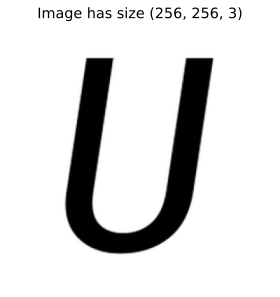

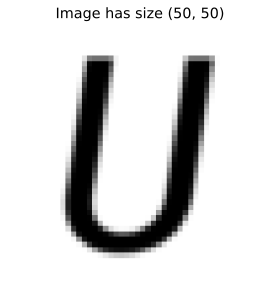

In [21]:
for batch in dummy_batch:
  original_image=batch[0][0]
  show_img(original_image)
  show_img(transforms_all(transforms.ToPILImage()(original_image)))
  break

### Separação em dados de treino e validação

**Etapas**

3. Separa parte dos dados em treinamento e validação.
    * São utilizadas apenas as primeiras 134 variações de fonte.
    * De cada variação, 42 imagens são copiadas para os dados de treino, e 20 imagens para os dados de validação.

In [24]:
folders=os.listdir(path)
count_folders_and_png_files(path, "Original Fonts")

shutil.rmtree(train_path)
shutil.rmtree(val_path)

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Podemos limitar em num_folders a quantidade total de pasta que iremos trabalhar, no total temos 1116.
num_folders = 134
count_folders = 1
for folder in folders:
    if count_folders <= num_folders:
      os.mkdir(f'{train_path}/{folder}')
      os.mkdir(f'{val_path}/{folder}')
      images = os.listdir(f'{path}/{folder}')
      random.shuffle(images)
      for image in images[:20]:
        shutil.copy(f'{path}/{folder}/{image}', f'{val_path}/{folder}/{image}')
      for image in images[20:]:
        shutil.copy(f'{path}/{folder}/{image}', f'{train_path}/{folder}/{image}')
    count_folders += 1

count_folders_and_png_files(train_path, "Train Fonts")
count_folders_and_png_files(val_path, "Val Fonts")

Original Fonts number of subfolders: 1,116
Original Fonts number of png files: 69,192
Train Fonts number of subfolders: 134
Train Fonts number of png files: 5,628
Val Fonts number of subfolders: 134
Val Fonts number of png files: 2,680


In [25]:
print(len(os.listdir(train_path)))
print(len(os.listdir(val_path)))

134
134


### Construção do Dataset e Dataloader

**Etapas**

4. Definição dos _DataLoaders_ de treinamento e validação.
    * Cada _DataLoader_ incorpora a redução de escala e transformação em imagens em escala de cinza.

In [26]:
transforms_set = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor()
])

train_loader=torch.utils.data.DataLoader(
    datasets.ImageFolder(f'{train_path}',transform=transforms_set),
    batch_size=batch_size, shuffle=True
)

val_loader=torch.utils.data.DataLoader(
    datasets.ImageFolder(f'{val_path}',transform=transforms_set),
    batch_size=batch_size, shuffle=True
)

### Implementação VAE

**Etapas**

5. Definição da arquitetura do VAE
    * São utilizadas camadas densas.
    * Existem 3 elementos principais na arquitetura: **Encoder**, **Reparametrização** e **Decoder**.
    * **Encoder**:
        * Passa dados de entrada achatados (_flatten_) de dimensão 2500 para dimensão 1000. Seguido por ativação ReLU.
        * Passa dados da dimensão 1000 em duas camadas paralelas para a dimensão do espaço latente.
        * Cada dimensão do espaço latente é caracterizada por uma média ($\mu$) e um logarítimico da variância ($log(\sigma^2)$).
    * **Reparametrização**:
        * _Reamostra_ cada elemento do espaço latente em função das respectivas médias e logarítimicos da variância.

        $$
        \sigma = e^{0.5*log(\sigma^2)} \\
        x = \mu + \epsilon \sigma
        $$

        * A variável aleatória $\epsilon$ segue distribuição normal padrão: $\epsilon \sim \mathcal{N}(0, 1)$. 
    * **Decoder**:
        * Passa do espaço latente para a dimensão 1000, seguido de ativação ReLU.
        * Passa da dimensão 1000 de volta para a dimensão do dado original. A ativação sigmóide deixa os valores de saída dentro da faixa de variação do dado original: $[0,1]$.
        

In [46]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        z = 32 # Dimensão do espaço latente

        #ENCODER
        self.fc1 = nn.Linear(50*50,1000) # Camada densa do dado de entrada para dimensão 1000
        self.fc21 = nn.Linear(1000,z)   # Camada densa de dimensão 1000 para espaço latente z
        self.fc22 = nn.Linear(1000,z)   # Camada densa de dimensão 1000 para espaço latente z

        #DECODER
        self.fc3 = nn.Linear(z,1000)
        self.fc4 = nn.Linear(1000,50*50)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        # don't forget forward pass re-index
        mu, logvar = self.encode(x.view(-1, 50*50))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Implementação Loss Function

**Etapas**

6. Definição da função de perda.
    * Existem dois termos na função de perda: **Entropia Binária Cruzada** e **Divergente de Kullback-Leibler**.
    * **Entropia Binária Cruzada**:
        * Medida do quando as imagens original e reconstruída se parecem, pixel a pixel.
    * **Divergente de Kullback-Leibler**:
        * Medida do quanto a distribuição do espaço latente se aproxima de uma distribuição normal padrão.
    * Desta forma a otimização dos pesos da rede tem duplo objetivo: reconstruir as imagens de entrada ao mesmo tempo que busca uma representação no espaço latente que siga uma normal padrão.
    * Código original foi alterado para retornar termos da _loss_ separadamente.

In [47]:
def loss_function(recon_x, x, mu, logvar):

    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 50*50), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE.detach(), KLD.detach()

### Criação do Modelo

**Etapas**

6. Cria nova instância do modelo.

In [48]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=VAE().to(device)
print('Device: ',device)
model=VAE().to(device)
optimizer=optim.Adam(model.parameters(),lr=1e-3)

Device:  cuda


### Loops de Treinamento e Avaliação

**Etapas**

7. Rotina de avaliação:
    * Calcula a _loss_ média do conjunto de validação.
    * Guarda uma amostra comparando a figura original com a reconstruída.
8. Rotina para gerar novas amostras:
    * Guarda 64 amostras geradas a partir de amostragem no espaço latente.
9. Rotina de treino:
    * Treinamento realizado em mini-batches de 64 amostras e otimizador Adam.

In [49]:
def evaluate(epoch, evaluate_data=val_loader):

    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(evaluate_data):

            data=data.to(device)
            recon_batch,mu,logvar=model(data)
            loss, _, _ = loss_function(recon_batch,data,mu,logvar)
            val_loss += loss.item()

            if i == 0 and epoch%50==0:
                n = min(data.size(0), 16)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 50, 50)[:n]])
                save_image(comparison.cpu(),
                           './results/reconstruction_' + str(epoch) + '.png', nrow=n)

    val_loss /= len(evaluate_data.dataset)
    return val_loss


def sample_latent_space(epoch):
    with torch.no_grad():

        # how to sample from our latent space
        sample=torch.randn(64,32).to(device)
        sample=model.decode(sample).cpu()

        save_image(sample.view(64, 1, 50, 50),
                   './results/sample_' + str(epoch) + '.png')

In [50]:
train_losses,val_losses=[],[]
train_losses_bce,train_losses_kld=[],[]

def train(epoch):

    model.train()

    train_loss = 0
    train_loss_bce = 0
    train_loss_kld = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch:03d}', leave=False, disable=False)
    for data, _ in progress_bar:
        progress_bar.set_description(f'Epoch {epoch:03d}')

        data=data.to(device)
        optimizer.zero_grad()
        recon_batch,mu,logvar=model(data)

        loss, loss_bce, loss_kld = loss_function(recon_batch,data,mu,logvar)
        loss.backward()
        train_loss += loss.item()
        train_loss_bce += loss_bce.item()
        train_loss_kld += loss_kld.item()
        optimizer.step()

        progress_bar.set_postfix({'training_loss': f'{(loss.item() / len(data)):.3f}'})

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_loss_bce = train_loss_bce / len(train_loader.dataset)
    avg_train_loss_kld = train_loss_kld / len(train_loader.dataset)
    val_loss = evaluate(epoch, val_loader)
    print(f'Epoch {epoch:03d}: train={avg_train_loss:<8.3f} (BCE={avg_train_loss_bce:<8.3f}, KLD={avg_train_loss_kld:<8.3f}), val: {val_loss:<8.3f}')

    train_losses.append(avg_train_loss)
    train_losses_bce.append(avg_train_loss_bce)
    train_losses_kld.append(avg_train_loss_kld)
    val_losses.append(val_loss)

    if epoch%300==0:
        torch.save(model.state_dict(), f'./models/epoch_{epoch}.model')

### Treinamento

In [52]:
shutil.rmtree('./models/')
shutil.rmtree('./results/')

os.makedirs('./models/', exist_ok=True)
os.makedirs('./results/', exist_ok=True)


epochs = 3000

train_losses,val_losses=[],[]
train_losses_bce,train_losses_kld=[],[]

for epoch in range(1,epochs+1):
  train(epoch)
  if epoch%50==0:
    sample_latent_space(epoch)

np.savetxt('./models/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt('./models/training_losses_bce.txt', np.array(train_losses_bce), delimiter='\n')
np.savetxt('./models/training_losses_kld.txt', np.array(train_losses_kld), delimiter='\n')
np.savetxt('./models/validation_losses.txt', np.array(val_losses), delimiter='\n')

Epoch 001:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 001: train=350.958  (BCE=311.058 , KLD=39.900  ), val: 346.768 


Epoch 002:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 002: train=339.191  (BCE=298.351 , KLD=40.840  ), val: 341.027 


Epoch 003:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 003: train=328.348  (BCE=287.096 , KLD=41.252  ), val: 331.026 


Epoch 004:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 004: train=319.278  (BCE=276.950 , KLD=42.328  ), val: 323.212 


Epoch 005:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 005: train=312.349  (BCE=269.843 , KLD=42.505  ), val: 318.170 


Epoch 006:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 006: train=305.633  (BCE=262.969 , KLD=42.664  ), val: 311.617 


Epoch 007:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 007: train=299.534  (BCE=256.404 , KLD=43.130  ), val: 307.507 


Epoch 008:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 008: train=295.621  (BCE=252.279 , KLD=43.342  ), val: 304.068 


Epoch 009:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 009: train=292.443  (BCE=249.002 , KLD=43.442  ), val: 300.570 


Epoch 010:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 010: train=287.699  (BCE=244.178 , KLD=43.521  ), val: 298.865 


Epoch 011:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 011: train=285.642  (BCE=242.096 , KLD=43.545  ), val: 296.515 


Epoch 012:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 012: train=284.237  (BCE=240.484 , KLD=43.752  ), val: 301.859 


Epoch 013:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 013: train=279.987  (BCE=236.107 , KLD=43.881  ), val: 295.220 


Epoch 014:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 014: train=275.684  (BCE=231.800 , KLD=43.884  ), val: 292.519 


Epoch 015:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 015: train=274.368  (BCE=230.276 , KLD=44.091  ), val: 288.482 


Epoch 016:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 016: train=271.833  (BCE=227.808 , KLD=44.025  ), val: 287.567 


Epoch 017:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 017: train=270.111  (BCE=226.191 , KLD=43.920  ), val: 286.615 


Epoch 018:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 018: train=268.099  (BCE=224.153 , KLD=43.946  ), val: 289.227 


Epoch 019:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 019: train=266.535  (BCE=222.235 , KLD=44.300  ), val: 283.198 


Epoch 020:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 020: train=265.857  (BCE=221.813 , KLD=44.043  ), val: 283.051 


Epoch 021:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 021: train=262.307  (BCE=218.005 , KLD=44.303  ), val: 279.284 


Epoch 022:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 022: train=260.933  (BCE=216.748 , KLD=44.185  ), val: 281.090 


Epoch 023:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 023: train=260.359  (BCE=216.229 , KLD=44.131  ), val: 276.623 


Epoch 024:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 024: train=258.197  (BCE=213.932 , KLD=44.265  ), val: 276.654 


Epoch 025:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 025: train=257.005  (BCE=212.671 , KLD=44.334  ), val: 277.299 


Epoch 026:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 026: train=256.456  (BCE=212.020 , KLD=44.436  ), val: 276.145 


Epoch 027:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 027: train=255.305  (BCE=210.862 , KLD=44.443  ), val: 277.605 


Epoch 028:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 028: train=253.695  (BCE=209.252 , KLD=44.443  ), val: 274.906 


Epoch 029:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 029: train=252.281  (BCE=207.799 , KLD=44.481  ), val: 274.544 


Epoch 030:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 030: train=251.877  (BCE=207.258 , KLD=44.619  ), val: 275.428 


Epoch 031:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 031: train=251.631  (BCE=206.996 , KLD=44.635  ), val: 273.314 


Epoch 032:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 032: train=250.023  (BCE=205.325 , KLD=44.698  ), val: 272.618 


Epoch 033:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 033: train=248.732  (BCE=204.022 , KLD=44.710  ), val: 269.367 


Epoch 034:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 034: train=247.902  (BCE=203.246 , KLD=44.655  ), val: 268.829 


Epoch 035:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 035: train=246.227  (BCE=201.530 , KLD=44.697  ), val: 269.949 


Epoch 036:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 036: train=246.139  (BCE=201.312 , KLD=44.827  ), val: 269.249 


Epoch 037:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 037: train=246.505  (BCE=201.819 , KLD=44.687  ), val: 269.849 


Epoch 038:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 038: train=244.317  (BCE=199.429 , KLD=44.888  ), val: 269.143 


Epoch 039:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 039: train=244.000  (BCE=199.171 , KLD=44.829  ), val: 267.223 


Epoch 040:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 040: train=243.065  (BCE=198.192 , KLD=44.873  ), val: 269.407 


Epoch 041:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 041: train=242.803  (BCE=197.757 , KLD=45.046  ), val: 268.654 


Epoch 042:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 042: train=242.091  (BCE=197.118 , KLD=44.973  ), val: 266.744 


Epoch 043:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 043: train=241.666  (BCE=196.608 , KLD=45.057  ), val: 268.245 


Epoch 044:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 044: train=241.535  (BCE=196.332 , KLD=45.203  ), val: 269.154 


Epoch 045:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 045: train=242.375  (BCE=197.139 , KLD=45.236  ), val: 267.236 


Epoch 046:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 046: train=239.557  (BCE=194.533 , KLD=45.024  ), val: 266.203 


Epoch 047:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 047: train=238.623  (BCE=193.534 , KLD=45.089  ), val: 267.941 


Epoch 048:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 048: train=239.171  (BCE=194.089 , KLD=45.082  ), val: 267.222 


Epoch 049:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 049: train=239.898  (BCE=194.593 , KLD=45.305  ), val: 266.659 


Epoch 050:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 050: train=237.468  (BCE=192.366 , KLD=45.102  ), val: 267.087 


Epoch 051:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 051: train=237.495  (BCE=192.297 , KLD=45.198  ), val: 266.658 


Epoch 052:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 052: train=236.764  (BCE=191.464 , KLD=45.300  ), val: 265.449 


Epoch 053:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 053: train=237.347  (BCE=192.018 , KLD=45.328  ), val: 264.322 


Epoch 054:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 054: train=235.735  (BCE=190.659 , KLD=45.076  ), val: 267.011 


Epoch 055:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 055: train=235.528  (BCE=190.122 , KLD=45.406  ), val: 268.256 


Epoch 056:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 056: train=235.738  (BCE=190.422 , KLD=45.316  ), val: 268.134 


Epoch 057:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 057: train=234.666  (BCE=189.266 , KLD=45.400  ), val: 264.712 


Epoch 058:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 058: train=234.392  (BCE=189.210 , KLD=45.181  ), val: 264.490 


Epoch 059:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 059: train=234.219  (BCE=188.958 , KLD=45.261  ), val: 265.907 


Epoch 060:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 060: train=234.373  (BCE=189.045 , KLD=45.329  ), val: 265.509 


Epoch 061:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 061: train=233.406  (BCE=187.929 , KLD=45.477  ), val: 265.491 


Epoch 062:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 062: train=234.235  (BCE=188.913 , KLD=45.321  ), val: 270.491 


Epoch 063:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 063: train=233.018  (BCE=187.379 , KLD=45.639  ), val: 267.618 


Epoch 064:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 064: train=233.119  (BCE=187.527 , KLD=45.591  ), val: 266.386 


Epoch 065:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 065: train=232.623  (BCE=187.046 , KLD=45.577  ), val: 265.803 


Epoch 066:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 066: train=231.077  (BCE=185.635 , KLD=45.442  ), val: 265.879 


Epoch 067:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 067: train=232.387  (BCE=186.784 , KLD=45.602  ), val: 269.151 


Epoch 068:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 068: train=231.884  (BCE=186.436 , KLD=45.448  ), val: 265.957 


Epoch 069:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 069: train=230.309  (BCE=184.720 , KLD=45.589  ), val: 265.202 


Epoch 070:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 070: train=231.027  (BCE=185.457 , KLD=45.569  ), val: 265.829 


Epoch 071:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 071: train=230.102  (BCE=184.460 , KLD=45.642  ), val: 264.937 


Epoch 072:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 072: train=230.680  (BCE=185.156 , KLD=45.523  ), val: 265.304 


Epoch 073:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 073: train=228.957  (BCE=183.476 , KLD=45.482  ), val: 264.639 


Epoch 074:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 074: train=229.456  (BCE=183.826 , KLD=45.630  ), val: 264.609 


Epoch 075:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 075: train=228.720  (BCE=183.015 , KLD=45.704  ), val: 264.775 


Epoch 076:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 076: train=229.226  (BCE=183.538 , KLD=45.688  ), val: 265.213 


Epoch 077:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 077: train=228.817  (BCE=183.104 , KLD=45.713  ), val: 266.068 


Epoch 078:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 078: train=227.857  (BCE=182.177 , KLD=45.679  ), val: 263.548 


Epoch 079:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 079: train=228.324  (BCE=182.764 , KLD=45.561  ), val: 267.505 


Epoch 080:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 080: train=228.374  (BCE=182.656 , KLD=45.718  ), val: 266.673 


Epoch 081:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 081: train=227.840  (BCE=182.247 , KLD=45.593  ), val: 262.623 


Epoch 082:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 082: train=228.393  (BCE=182.619 , KLD=45.773  ), val: 263.267 


Epoch 083:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 083: train=228.118  (BCE=182.388 , KLD=45.730  ), val: 266.380 


Epoch 084:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 084: train=227.329  (BCE=181.743 , KLD=45.586  ), val: 264.966 


Epoch 085:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 085: train=226.651  (BCE=180.903 , KLD=45.747  ), val: 264.221 


Epoch 086:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 086: train=227.558  (BCE=181.751 , KLD=45.807  ), val: 267.046 


Epoch 087:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 087: train=226.950  (BCE=181.246 , KLD=45.703  ), val: 265.145 


Epoch 088:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 088: train=226.358  (BCE=180.567 , KLD=45.791  ), val: 263.029 


Epoch 089:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 089: train=226.094  (BCE=180.263 , KLD=45.832  ), val: 266.344 


Epoch 090:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 090: train=225.602  (BCE=179.731 , KLD=45.872  ), val: 267.284 


Epoch 091:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 091: train=225.746  (BCE=179.921 , KLD=45.824  ), val: 264.207 


Epoch 092:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 092: train=225.320  (BCE=179.591 , KLD=45.729  ), val: 265.142 


Epoch 093:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 093: train=225.632  (BCE=179.696 , KLD=45.936  ), val: 268.169 


Epoch 094:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 094: train=224.626  (BCE=178.968 , KLD=45.658  ), val: 263.799 


Epoch 095:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 095: train=224.730  (BCE=178.917 , KLD=45.813  ), val: 267.375 


Epoch 096:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 096: train=225.674  (BCE=179.813 , KLD=45.860  ), val: 267.829 


Epoch 097:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 097: train=225.769  (BCE=179.929 , KLD=45.840  ), val: 265.547 


Epoch 098:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 098: train=224.428  (BCE=178.563 , KLD=45.865  ), val: 265.262 


Epoch 099:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 099: train=224.710  (BCE=178.609 , KLD=46.100  ), val: 267.109 


Epoch 100:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 100: train=223.755  (BCE=177.831 , KLD=45.924  ), val: 263.794 


Epoch 101:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 101: train=224.232  (BCE=178.217 , KLD=46.015  ), val: 269.190 


Epoch 102:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 102: train=224.306  (BCE=178.360 , KLD=45.947  ), val: 265.438 


Epoch 103:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 103: train=223.363  (BCE=177.501 , KLD=45.862  ), val: 264.804 


Epoch 104:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 104: train=223.487  (BCE=177.716 , KLD=45.771  ), val: 265.744 


Epoch 105:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 105: train=223.566  (BCE=177.658 , KLD=45.908  ), val: 266.059 


Epoch 106:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 106: train=223.415  (BCE=177.581 , KLD=45.834  ), val: 264.563 


Epoch 107:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 107: train=223.461  (BCE=177.521 , KLD=45.941  ), val: 263.516 


Epoch 108:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 108: train=222.922  (BCE=176.925 , KLD=45.998  ), val: 266.141 


Epoch 109:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 109: train=222.409  (BCE=176.544 , KLD=45.865  ), val: 267.189 


Epoch 110:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 110: train=222.501  (BCE=176.694 , KLD=45.807  ), val: 270.318 


Epoch 111:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 111: train=222.410  (BCE=176.463 , KLD=45.947  ), val: 264.534 


Epoch 112:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 112: train=222.374  (BCE=176.384 , KLD=45.990  ), val: 269.956 


Epoch 113:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 113: train=222.736  (BCE=176.617 , KLD=46.119  ), val: 266.002 


Epoch 114:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 114: train=222.279  (BCE=176.402 , KLD=45.877  ), val: 266.663 


Epoch 115:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 115: train=222.946  (BCE=176.849 , KLD=46.097  ), val: 265.070 


Epoch 116:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 116: train=221.627  (BCE=175.687 , KLD=45.940  ), val: 265.483 


Epoch 117:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 117: train=222.448  (BCE=176.508 , KLD=45.940  ), val: 265.199 


Epoch 118:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 118: train=221.704  (BCE=175.649 , KLD=46.055  ), val: 263.356 


Epoch 119:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 119: train=221.650  (BCE=175.843 , KLD=45.806  ), val: 268.369 


Epoch 120:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 120: train=221.615  (BCE=175.579 , KLD=46.036  ), val: 264.753 


Epoch 121:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 121: train=221.540  (BCE=175.490 , KLD=46.050  ), val: 268.631 


Epoch 122:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 122: train=221.573  (BCE=175.593 , KLD=45.980  ), val: 267.381 


Epoch 123:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 123: train=220.839  (BCE=174.824 , KLD=46.015  ), val: 266.464 


Epoch 124:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 124: train=220.587  (BCE=174.672 , KLD=45.915  ), val: 266.397 


Epoch 125:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 125: train=221.701  (BCE=175.791 , KLD=45.909  ), val: 264.914 


Epoch 126:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 126: train=219.986  (BCE=173.914 , KLD=46.072  ), val: 267.790 


Epoch 127:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 127: train=221.242  (BCE=175.221 , KLD=46.021  ), val: 267.109 


Epoch 128:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 128: train=220.229  (BCE=174.215 , KLD=46.014  ), val: 268.219 


Epoch 129:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 129: train=220.719  (BCE=174.541 , KLD=46.178  ), val: 267.757 


Epoch 130:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 130: train=219.966  (BCE=173.983 , KLD=45.984  ), val: 265.975 


Epoch 131:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 131: train=220.307  (BCE=174.345 , KLD=45.962  ), val: 267.192 


Epoch 132:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 132: train=220.155  (BCE=174.183 , KLD=45.971  ), val: 264.833 


Epoch 133:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 133: train=219.104  (BCE=172.997 , KLD=46.107  ), val: 267.678 


Epoch 134:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 134: train=219.823  (BCE=173.842 , KLD=45.981  ), val: 267.056 


Epoch 135:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 135: train=220.421  (BCE=174.400 , KLD=46.020  ), val: 264.501 


Epoch 136:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 136: train=220.038  (BCE=174.037 , KLD=46.001  ), val: 268.845 


Epoch 137:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 137: train=219.687  (BCE=173.651 , KLD=46.036  ), val: 267.428 


Epoch 138:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 138: train=219.395  (BCE=173.346 , KLD=46.049  ), val: 268.938 


Epoch 139:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 139: train=219.763  (BCE=173.747 , KLD=46.016  ), val: 267.405 


Epoch 140:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 140: train=219.602  (BCE=173.538 , KLD=46.064  ), val: 265.440 


Epoch 141:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 141: train=219.170  (BCE=173.180 , KLD=45.990  ), val: 266.926 


Epoch 142:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 142: train=219.343  (BCE=173.121 , KLD=46.222  ), val: 266.506 


Epoch 143:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 143: train=219.152  (BCE=173.064 , KLD=46.088  ), val: 264.965 


Epoch 144:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 144: train=218.594  (BCE=172.475 , KLD=46.119  ), val: 265.900 


Epoch 145:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 145: train=218.825  (BCE=172.752 , KLD=46.074  ), val: 268.544 


Epoch 146:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 146: train=218.020  (BCE=172.039 , KLD=45.981  ), val: 265.097 


Epoch 147:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 147: train=218.659  (BCE=172.461 , KLD=46.198  ), val: 266.409 


Epoch 148:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 148: train=219.301  (BCE=173.163 , KLD=46.138  ), val: 265.459 


Epoch 149:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 149: train=218.481  (BCE=172.401 , KLD=46.080  ), val: 265.113 


Epoch 150:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 150: train=218.937  (BCE=172.902 , KLD=46.034  ), val: 266.077 


Epoch 151:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 151: train=217.402  (BCE=171.327 , KLD=46.075  ), val: 265.730 


Epoch 152:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 152: train=217.670  (BCE=171.552 , KLD=46.118  ), val: 266.936 


Epoch 153:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 153: train=217.604  (BCE=171.466 , KLD=46.138  ), val: 267.680 


Epoch 154:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 154: train=217.654  (BCE=171.676 , KLD=45.978  ), val: 266.301 


Epoch 155:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 155: train=217.430  (BCE=171.408 , KLD=46.022  ), val: 269.460 


Epoch 156:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 156: train=218.068  (BCE=172.031 , KLD=46.036  ), val: 271.594 


Epoch 157:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 157: train=218.532  (BCE=172.419 , KLD=46.113  ), val: 266.477 


Epoch 158:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 158: train=216.968  (BCE=170.916 , KLD=46.052  ), val: 268.525 


Epoch 159:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 159: train=217.073  (BCE=170.911 , KLD=46.162  ), val: 266.295 


Epoch 160:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 160: train=217.316  (BCE=171.305 , KLD=46.011  ), val: 268.702 


Epoch 161:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 161: train=217.256  (BCE=171.134 , KLD=46.122  ), val: 268.089 


Epoch 162:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 162: train=217.650  (BCE=171.531 , KLD=46.119  ), val: 272.527 


Epoch 163:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 163: train=217.196  (BCE=171.151 , KLD=46.046  ), val: 269.764 


Epoch 164:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 164: train=216.189  (BCE=170.112 , KLD=46.078  ), val: 266.858 


Epoch 165:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 165: train=217.148  (BCE=171.064 , KLD=46.085  ), val: 268.412 


Epoch 166:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 166: train=217.115  (BCE=171.005 , KLD=46.110  ), val: 267.725 


Epoch 167:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 167: train=216.876  (BCE=170.671 , KLD=46.204  ), val: 268.291 


Epoch 168:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 168: train=216.250  (BCE=170.279 , KLD=45.971  ), val: 272.344 


Epoch 169:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 169: train=216.621  (BCE=170.517 , KLD=46.105  ), val: 266.148 


Epoch 170:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 170: train=216.236  (BCE=170.228 , KLD=46.008  ), val: 271.045 


Epoch 171:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 171: train=217.861  (BCE=171.712 , KLD=46.150  ), val: 267.967 


Epoch 172:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 172: train=216.703  (BCE=170.642 , KLD=46.061  ), val: 266.862 


Epoch 173:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 173: train=216.444  (BCE=170.257 , KLD=46.187  ), val: 266.873 


Epoch 174:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 174: train=216.156  (BCE=170.173 , KLD=45.983  ), val: 269.420 


Epoch 175:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 175: train=216.842  (BCE=170.692 , KLD=46.150  ), val: 267.063 


Epoch 176:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 176: train=216.433  (BCE=170.244 , KLD=46.189  ), val: 269.101 


Epoch 177:   0%|          | 0/88 [00:00<?, ?it/s]

KeyboardInterrupt: 

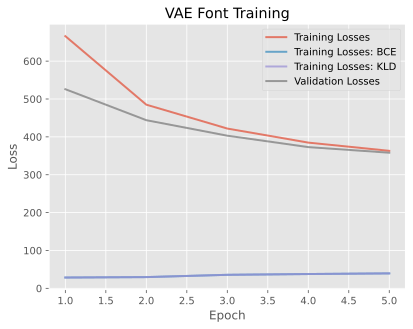

In [44]:
train_losses=np.loadtxt('./models/training_losses.txt')
train_losses_bce=np.loadtxt('./models/training_losses_bce.txt')
train_losses_bce=np.loadtxt('./models/training_losses_kld.txt')
val_losses=np.loadtxt('./models/validation_losses.txt')

plt.plot(
    range(1,len(train_losses)+1),
    train_losses,
    label='Training Losses',
    linewidth=2,
    alpha=0.7
)
plt.plot(
    range(1,len(train_losses)+1),
    train_losses_bce,
    label='Training Losses: BCE',
    linewidth=2,
    alpha=0.7
)
plt.plot(
    range(1,len(train_losses)+1),
    train_losses_kld,
    label='Training Losses: KLD',
    linewidth=2,
    alpha=0.7
)
plt.plot(
    range(1,len(val_losses)+1),
    val_losses,
    label='Validation Losses',
    linewidth=2,
    alpha=0.7
)

plt.title('VAE Font Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
pass

In [ ]:
model.load_state_dict(
    torch.load('./models/epoch_900.model',
               map_location=torch.device('cpu')))

sample_latent_space('a')

In [ ]:
# Zipa os resultados para download
!zip -r results.zip ./results
!zip -r models.zip ./models

In [ ]:
# Baixa arquivos para o pc local
# from google.colab import files
# files.download('/content/models.zip')
# files.download('/content/results.zip')